# Определение перспективного тарифа для телеком-компании

Компания «Мегалайн» — федеральный оператор сотовой связи - прелагает клиентам два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов из 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов
<B>Тариф «Смарт»</B>

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.
    
<B>Тариф «Ультра»</B>

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

Импортируем нужные библиотеки.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as math
from scipy import stats as st
import seaborn as sns
import warnings
import re
warnings.filterwarnings('ignore')

## Изучение данных из файла

Откроем файлы и посмотрим по ним основную информацию.

In [ ]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
display(tariffs.head(10))
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Это таблица с описанием тарифов, без пропусков и с верными типами данных. Оставим ее пока в этом виде.

In [ ]:
users = pd.read_csv('/datasets/users.csv', parse_dates=['reg_date'])
display(users.head(10))
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


В таблице с информацией о пользователях есть пропуски в столбце с датой закрытия контракта. Тип данных в столбцах с датами не совпадает с указанным, возможно, его надо будет заменить. Кроме того, информации достаточно много, скорее всего, для работы вся она нам не понадобится. 

In [ ]:
calls = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])
display(calls.head(10))
calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Опять не совпадает тип данных в столбце с датой, а в столбце с продолжительностью разговора много нулей. Зато нет пропусков.

In [ ]:
messages = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])
display(messages.tail(10))
messages.info()

,id,message_date,user_id
123026,1499_174,2018-12-14,1499
123027,1499_175,2018-10-09,1499
123028,1499_176,2018-12-17,1499
123029,1499_177,2018-12-30,1499
123030,1499_178,2018-10-25,1499
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499
123035,1499_183,2018-11-16,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Опять ни одного пропуска, тип столбца с датой - object, в остальном все смотрится нормально.

In [ ]:
internet = pd.read_csv('/datasets/internet.csv', parse_dates=['session_date'])
display(internet.head(10))
internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


И этот датафрейм похож на предыдущие. Также надо учесть, что здесь использование мобильного интернета измеряется в Мб.

В целом, данные выглядят неплохо - почти нет пропусков, типы данных также почти везде приведены правильные. Осталось их немного подготовить к дальнейшим расчетам.

In [ ]:
df_list = [tariffs, users, calls, messages, internet]
for i in df_list:
    print(i.duplicated().sum())

0
0
0
0
0


Дубликатов нет, можно приступать к подготовке данных.

## Подготовка данных

### Users

В датафрейме с информацией о пользователях есть пропуски в столбце с датой закрытия контракта. Проверим, какие вообще варианты дат есть, и увидим, что все они за 2018 год. Поэтому для удобства расчетов на всякий случай заменим пропуски на последний день этого года.

In [ ]:
users['churn_date'].unique()

array([nan, '2018-10-05', '2018-12-18', '2018-11-21', '2018-10-03',
       '2018-10-14', '2018-12-09', '2018-12-11', '2018-12-26',
       '2018-08-31', '2018-12-03', '2018-12-23', '2018-11-07',
       '2018-12-16', '2018-12-20', '2018-11-30', '2018-12-21',
       '2018-08-17', '2018-09-02', '2018-10-04', '2018-11-13',
       '2018-11-22', '2018-10-28', '2018-11-26', '2018-11-27',
       '2018-11-16', '2018-10-27', '2018-12-30', '2018-09-27',
       '2018-12-25', '2018-12-14', '2018-12-24', '2018-09-26',
       '2018-10-25'], dtype=object)

In [ ]:
users['churn_date'] = users['churn_date'].fillna('2018-12-31')

Из задания видно, что для дальнейших расчетов нам не нужны будут все данные о пользователях, достаточно будет всего трех столбцов. Выделим их в отдельную таблицу, чтобы использовать позднее.

In [ ]:
users_info = users[['user_id', 'tariff', 'city']]

In [ ]:
display(users_info.head(5))

,user_id,tariff,city
0,1000,ultra,Краснодар
1,1001,smart,Москва
2,1002,smart,Стерлитамак
3,1003,ultra,Москва
4,1004,ultra,Новокузнецк


### Calls

Для расчетов нам не нужны будут точные даты, достаточно месяца. Приведем дату к нужному типу данных и выделим месяц в отдельный столбец. 

In [ ]:
calls['month'] = pd.to_datetime(calls['call_date']).dt.month

По условиям компании все звонки тарифицируются поминутно, округлим их длительность в большую сторону.

In [ ]:
calls['duration'] = math.ceil(calls['duration'])

In [ ]:
display(calls.head(10))

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
5,1000_5,2018-11-02,0.0,1000,11
6,1000_6,2018-10-18,0.0,1000,10
7,1000_7,2018-08-22,19.0,1000,8
8,1000_8,2018-09-15,19.0,1000,9
9,1000_9,2018-08-15,0.0,1000,8


Чтобы узнать стоимость платежа, нужно посчитать общую продолжительность разговоров в месяц, также для статистики посмотрим и количество звонков. Выделим данные, которые нам понадобятся для дальнейшей работы, а также переименуем столбцы в получившемся датафрейме.

In [ ]:
calls = calls.groupby(['user_id', 'month']).agg({'duration': ['sum', 'count']}).reset_index()

In [ ]:
calls.columns = ['user_id', 'month', 'call_time', 'calls_total']

In [ ]:
display(calls)

,user_id,month,call_time,calls_total
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58
...,...,...,...,...
3169,1498,10,247.0,41
3170,1499,9,70.0,9
3171,1499,10,449.0,68
3172,1499,11,612.0,74


### Messages

По подобию изменим и таблицу по сообщениям: выделим месяц в отдельный столбец, а затем посчитаем общее число сообщений. Оставим в таблице только нужные нам данные.

In [ ]:
messages['month'] = messages['message_date'].dt.month

In [ ]:
messages = messages.groupby(['user_id', 'month']).agg({'message_date': 'count'}).reset_index()

In [ ]:
messages.columns = ['user_id', 'month', 'messages_total']

In [ ]:
display(messages.head(10))

,user_id,month,messages_total
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


### Internet

Проделаем ту же работу и с данными по использованию интернета. Для подсчета платежа абонента посчитаем сначала общую сумму использованных мегабайт за месяц, затем переведем Мб в Гб и округлим в бОльшую сторону.

In [ ]:
internet['month'] = internet['session_date'].dt.month

In [ ]:
internet = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()

In [ ]:
mb_in_gb = 1024

In [ ]:
internet['mb_used'] = internet['mb_used'] / mb_in_gb

In [ ]:
internet.columns = ['user_id', 'month', 'gb_used']

In [ ]:
display(internet.head(5))

,user_id,month,gb_used
0,1000,5,2.200674
1,1000,6,22.689229
2,1000,7,13.675430
3,1000,8,13.726494
4,1000,9,14.227451


In [ ]:
internet['gb_used'] = math.ceil(internet['gb_used'])

In [ ]:
display(internet.head(5))

,user_id,month,gb_used
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0


Мы вычислили, как использовали пользователи свои тарифные пакеты, теперь посчитаем выручку с каждого абонента. Для этого нужные данные объединим в одну таблицу.

In [ ]:
new_data = calls.merge(messages, on=['user_id', 'month'],  how='outer' ) \
    .merge(internet, on=['user_id', 'month'], how='outer' ) \
    .merge(users_info, on=['user_id'], how='left' )

In [ ]:
display(new_data.head(10))

,user_id,month,call_time,calls_total,messages_total,gb_used,tariff,city
0,1000,5,159.0,22.0,22.0,3.0,ultra,Краснодар
1,1000,6,172.0,43.0,60.0,23.0,ultra,Краснодар
2,1000,7,340.0,47.0,75.0,14.0,ultra,Краснодар
3,1000,8,408.0,52.0,81.0,14.0,ultra,Краснодар
4,1000,9,466.0,58.0,57.0,15.0,ultra,Краснодар
5,1000,10,350.0,57.0,73.0,15.0,ultra,Краснодар
6,1000,11,338.0,43.0,58.0,15.0,ultra,Краснодар
7,1000,12,333.0,46.0,70.0,10.0,ultra,Краснодар
8,1001,11,430.0,59.0,NaN,18.0,smart,Москва
9,1001,12,414.0,63.0,NaN,14.0,smart,Москва


In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
user_id           3214 non-null int64
month             3214 non-null int64
call_time         3174 non-null float64
calls_total       3174 non-null float64
messages_total    2717 non-null float64
gb_used           3203 non-null float64
tariff            3214 non-null object
city              3214 non-null object
dtypes: float64(4), int64(2), object(2)
memory usage: 226.0+ KB


Появились пропуски, так как не все пользователи используют весь пакет каждый месяц. Заменим пропуски нулями, а также поменяем тип данных.

In [ ]:
new_data = new_data.fillna(0)

In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
user_id           3214 non-null int64
month             3214 non-null int64
call_time         3214 non-null float64
calls_total       3214 non-null float64
messages_total    3214 non-null float64
gb_used           3214 non-null float64
tariff            3214 non-null object
city              3214 non-null object
dtypes: float64(4), int64(2), object(2)
memory usage: 226.0+ KB


In [ ]:
new_data.month = new_data.month.astype(int)
new_data.calls_total = new_data.calls_total.astype(int)
new_data.messages_total = new_data.messages_total.astype(int)

In [ ]:
display(new_data.head(5))

,user_id,month,call_time,calls_total,messages_total,gb_used,tariff,city
0,1000,5,159.0,22,22,3.0,ultra,Краснодар
1,1000,6,172.0,43,60,23.0,ultra,Краснодар
2,1000,7,340.0,47,75,14.0,ultra,Краснодар
3,1000,8,408.0,52,81,14.0,ultra,Краснодар
4,1000,9,466.0,58,57,15.0,ultra,Краснодар


Для подсчета платежа за месяц и выручки нам нужны данные из таблицы с условиями тарифа. Добавим в наш дата фрейм и эту таблицу.

In [ ]:
data_tariff = new_data.merge(tariffs, left_on='tariff', right_on='tariff_name',  how='left' )

In [ ]:
display(data_tariff.head(10))

,user_id,month,call_time,calls_total,messages_total,gb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5,159.0,22,22,3.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra
1,1000,6,172.0,43,60,23.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra
2,1000,7,340.0,47,75,14.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra
3,1000,8,408.0,52,81,14.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra
4,1000,9,466.0,58,57,15.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra
5,1000,10,350.0,57,73,15.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra
6,1000,11,338.0,43,58,15.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra
7,1000,12,333.0,46,70,10.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra
8,1001,11,430.0,59,0,18.0,smart,Москва,50,15360,500,550,200,3,3,smart
9,1001,12,414.0,63,0,14.0,smart,Москва,50,15360,500,550,200,3,3,smart


In [ ]:
data_tariff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
user_id                  3214 non-null int64
month                    3214 non-null int64
call_time                3214 non-null float64
calls_total              3214 non-null int64
messages_total           3214 non-null int64
gb_used                  3214 non-null float64
tariff                   3214 non-null object
city                     3214 non-null object
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minute           3214 non-null int64
tariff_name              3214 non-null object
dtypes: float64(2), int64(11), object(3)
memory usage: 426.9+ KB


Создадим функцию для подсчета платы за месяц. Чтобы узнать, нужно ли доплачивать сверх абонентской платы, найдем разницу между включенными и потраченными единицами, а в случае превышения пакета посчитаем размер доплаты. Затем сложим абонентскую плату и доплаты. Применим функцию к нашему датафрейму и построим гистограмму выручки, чтобы посмотреть картину наглядно.

In [ ]:
def count_revenue(data):
    if (data['messages_total'] - data['messages_included']) > 0:
        messages_fee = (data['messages_total'] - data['messages_included']) * data['rub_per_message']
    else:
        messages_fee = 0
    
    
    if (data['calls_total'] - data['minutes_included']) > 0:
        calls_fee = (data['calls_total'] - data['minutes_included']) * data['rub_per_minute']
    else:
        calls_fee = 0
    

    if (data['gb_used'] - (data['mb_per_month_included'] / 1024)) > 0:
        internet_fee = (data['gb_used'] - (data['mb_per_month_included'] / 1024)) * data['rub_per_gb']
    else:
        internet_fee = 0
    
    monthly_fee = data['rub_monthly_fee']
    
    user_revenue = monthly_fee + messages_fee + calls_fee + internet_fee
    return user_revenue

data_tariff['revenue'] = data_tariff.apply(count_revenue, axis = 1)
display(data_tariff.head(10))

,user_id,month,call_time,calls_total,messages_total,gb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue
0,1000,5,159.0,22,22,3.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
1,1000,6,172.0,43,60,23.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
2,1000,7,340.0,47,75,14.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
3,1000,8,408.0,52,81,14.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
4,1000,9,466.0,58,57,15.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
5,1000,10,350.0,57,73,15.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
6,1000,11,338.0,43,58,15.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
7,1000,12,333.0,46,70,10.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
8,1001,11,430.0,59,0,18.0,smart,Москва,50,15360,500,550,200,3,3,smart,1150.0
9,1001,12,414.0,63,0,14.0,smart,Москва,50,15360,500,550,200,3,3,smart,550.0


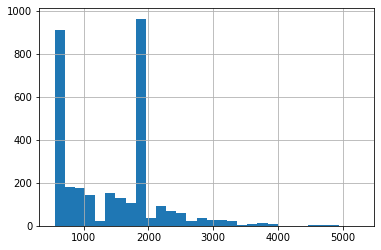

In [ ]:
data_tariff['revenue'].hist(bins=30)

In [ ]:
data_tariff['revenue'].value_counts()

1950.0    939
550.0     721
950.0     131
1150.0    120
750.0     117
         ... 
989.0       1
2180.0      1
1855.0      1
3410.0      1
2055.0      1
Name: revenue, Length: 356, dtype: int64

Как и ожидалось, самые распространенные значения - величины абонентской платы. За ними идут суммы в промежутке между этими цифрами, хвост же идет, снижаясь и прерываясь, к 5000. 

## Анализ данных

Разделим данные на две таблицы в зависимости от тарифа.

In [ ]:
smart_data = data_tariff[data_tariff['tariff'] == 'smart'].copy()
ultra_data = data_tariff[data_tariff['tariff'] == 'ultra'].copy()

In [ ]:
ultra_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 0 to 3213
Data columns (total 17 columns):
user_id                  985 non-null int64
month                    985 non-null int64
call_time                985 non-null float64
calls_total              985 non-null int64
messages_total           985 non-null int64
gb_used                  985 non-null float64
tariff                   985 non-null object
city                     985 non-null object
messages_included        985 non-null int64
mb_per_month_included    985 non-null int64
minutes_included         985 non-null int64
rub_monthly_fee          985 non-null int64
rub_per_gb               985 non-null int64
rub_per_message          985 non-null int64
rub_per_minute           985 non-null int64
tariff_name              985 non-null object
revenue                  985 non-null float64
dtypes: float64(3), int64(11), object(3)
memory usage: 138.5+ KB


In [ ]:
ultra_data.head()

,user_id,month,call_time,calls_total,messages_total,gb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,revenue
0,1000,5,159.0,22,22,3.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
1,1000,6,172.0,43,60,23.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
2,1000,7,340.0,47,75,14.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
3,1000,8,408.0,52,81,14.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0
4,1000,9,466.0,58,57,15.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,ultra,1950.0


In [ ]:
smart_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 8 to 3212
Data columns (total 17 columns):
user_id                  2229 non-null int64
month                    2229 non-null int64
call_time                2229 non-null float64
calls_total              2229 non-null int64
messages_total           2229 non-null int64
gb_used                  2229 non-null float64
tariff                   2229 non-null object
city                     2229 non-null object
messages_included        2229 non-null int64
mb_per_month_included    2229 non-null int64
minutes_included         2229 non-null int64
rub_monthly_fee          2229 non-null int64
rub_per_gb               2229 non-null int64
rub_per_message          2229 non-null int64
rub_per_minute           2229 non-null int64
tariff_name              2229 non-null object
revenue                  2229 non-null float64
dtypes: float64(3), int64(11), object(3)
memory usage: 313.5+ KB


Как мы видим, данных по абонентам тарифа "Ультра" в два раза меньше, чем тарифа "Смарт", что скорее всего, представляет и реальное распределение пользователей.

<B>Тариф «Смарт»</B>

Ежемесячная плата: 550 рублей

Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

In [ ]:
display(smart_data[['call_time', 'messages_total', 'gb_used', 'revenue']].describe())

,call_time,messages_total,gb_used,revenue
count,2229.000000,2229.000000,2229.000000,2229.000000
mean,417.934948,33.384029,16.328847,1165.156572
std,190.313730,28.227876,5.747061,740.556759
min,0.000000,0.000000,0.000000,550.000000
25%,282.000000,10.000000,13.000000,550.000000
50%,422.000000,28.000000,17.000000,950.000000
75%,545.000000,51.000000,20.000000,1550.000000
max,1435.000000,143.000000,38.000000,5249.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff08f09cf10>,
      dtype=object)

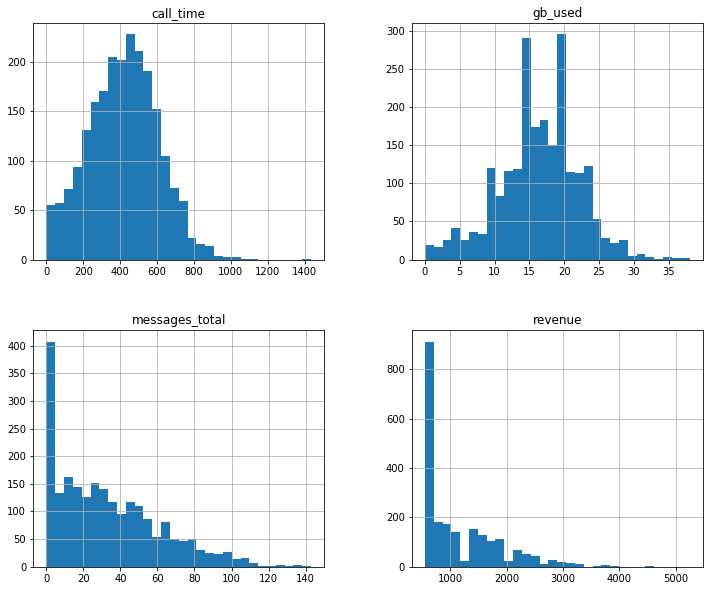

In [ ]:
display(smart_data[['call_time', 'messages_total', 'gb_used', 'revenue']].hist(figsize=(12,10), bins=30))

Около половины абонентов "Смарт" превышают входящие в тариф пакеты по звонкам и интернету, значит, платят за превышение лимитов. Зато сообщениями пользуются редко, только четверть превышает лимит, а большинство вообще их не отправляет.
Что касается интернета, то тех, кто вообще им не пользуется, довольно мало, больше всего тех пользователей, которые тратят 15 или 20 Гб. 
Только четверть абонентов платит только ежемесячную плату, большинство доплачивает еще и за потраченные минуты и гигабайты, причем, четверь пользователей платит сумму в три раза больше абонентской платы.

<B>Тариф «Ультра»</B>

Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

In [ ]:
display(ultra_data[['call_time', 'messages_total', 'gb_used', 'revenue']].describe())

,call_time,messages_total,gb_used,revenue
count,985.000000,985.000000,985.000000,985.000000
mean,526.623350,49.363452,19.494416,2070.152284
std,317.606098,47.804457,9.853511,376.187114
min,0.000000,0.000000,0.000000,1950.000000
25%,284.000000,6.000000,12.000000,1950.000000
50%,518.000000,38.000000,19.000000,1950.000000
75%,752.000000,79.000000,27.000000,1950.000000
max,1673.000000,224.000000,49.000000,4800.000000


In [ ]:
print("Доля пользователей, заплативших больше абонентской платы:", len(ultra_data[ultra_data['revenue'] > ultra_data['rub_monthly_fee'][0]]) / len(ultra_data['revenue']))

Доля пользователей, заплативших больше абонентской платы: 0.13604060913705585


In [ ]:
print('Доля абонентов "Ультра", потративших меньше пакета "Смарт":',\
      len(ultra_data[(ultra_data['call_time'] < tariffs['minutes_included'][0])\
      & (ultra_data['messages_total'] < tariffs['minutes_included'][0])\
      & (ultra_data['gb_used'] < (tariffs['mb_per_month_included'][0] / mb_in_gb))])/ \
      len(ultra_data['revenue']))

Доля абонентов "Ультра", потративших меньше пакета "Смарт": 0.18883248730964466


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff08ec37b10>,
      dtype=object)

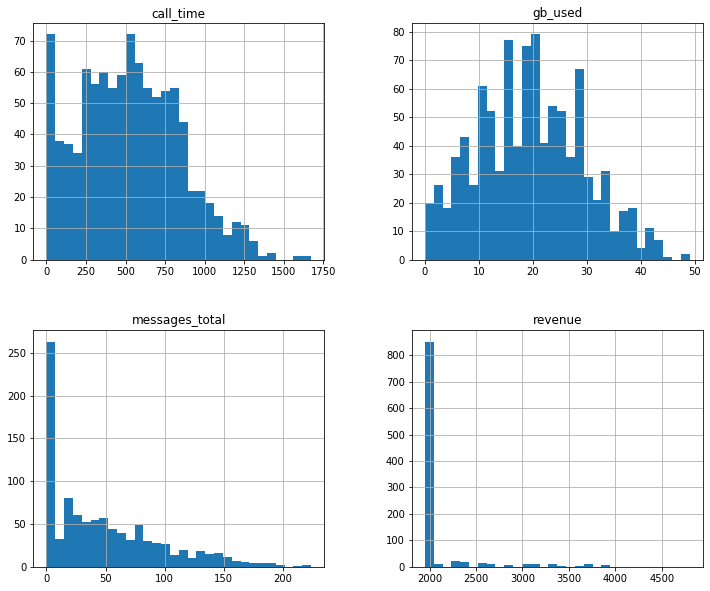

In [ ]:
display(ultra_data[['call_time', 'messages_total', 'gb_used', 'revenue']].hist(figsize=(12,10), bins=30))

По тарифу "Ультра" картина другая - пользователи даже близко не приближаются к лимитам по звонкам и сообщениям, только четверть превышает пакет интернета. Поэтому только 13% абонентов доплачивают сверх абонентской платы. Примерно 40% пользователей тратят меньше лимитов по тарифу "Смарт", причем, почти 13% недобирают лимиты этого тарифа сразу по всем трем категориям.
Что касается средних значений, то они выше, чем у пользователей другого тарифа, но не значительно - тратящие такие же объемы на тарифе "Смарт" платят меньше.
Здесь также не особо популярны сообщения, большинство пользователей их не отправляет вообще, есть также значимая доля пользователей, вообще не совершающих звонки. Интернетом эти абоненты пользуются активнее, но большинство остается в рамках лимитов.

In [ ]:
print('Дисперсия\n', np.var(smart_data[['call_time', 'messages_total', 'gb_used', 'revenue']]))

Дисперсия
 call_time          36203.066652
messages_total       796.455483
gb_used               33.013887
revenue           548178.272928
dtype: float64


In [ ]:
print('Математическое ожидание\n', (np.var(smart_data[['call_time', 'messages_total', 'gb_used', 'revenue']])**0.5))

Математическое ожидание
 call_time         190.271035
messages_total     28.221543
gb_used             5.745771
revenue           740.390622
dtype: float64


In [ ]:
print('Дисперсия\n', np.var(ultra_data[['call_time', 'messages_total', 'gb_used', 'revenue']]))

Дисперсия
 call_time         100771.223617
messages_total      2282.946075
gb_used               96.993116
revenue           141373.073256
dtype: float64


In [ ]:
print('Математическое ожидание\n', (np.var(ultra_data[['call_time', 'messages_total', 'gb_used', 'revenue']])**0.5))

Математическое ожидание
 call_time         317.444836
messages_total     47.780185
gb_used             9.848508
revenue           375.996108
dtype: float64


Построим диаграммы распределения по обеим таблицам.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff08ecc34d0>,
      dtype=object)

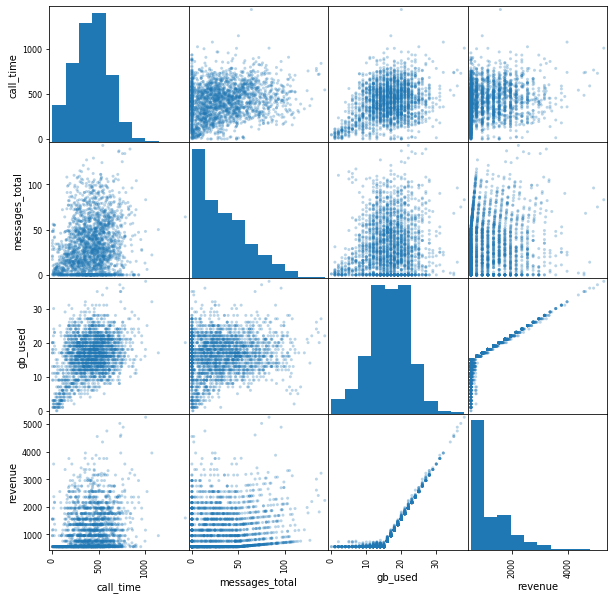

In [ ]:
pd.plotting.scatter_matrix(smart_data[['call_time', 'messages_total', 'gb_used', 'revenue']], alpha = 0.3, figsize = (10,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff084d7ac10>,
      dtype=object)

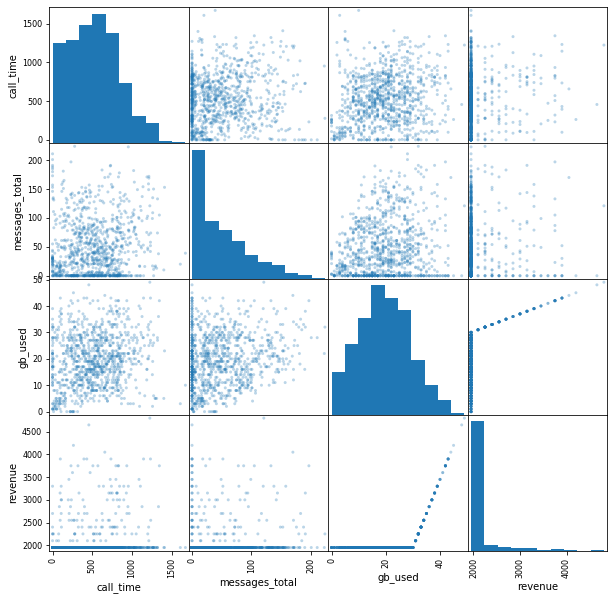

In [ ]:
pd.plotting.scatter_matrix(ultra_data[['call_time', 'messages_total', 'gb_used', 'revenue']], alpha = 0.3, figsize = (10,10))

В обоих тарифах выручка увеличивается за счет превышения абонентами лимитов на мобильный интернет. 

## Проверка гипотез

### Проверка гипотезы о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Нулевая гипотеза - средняя выручка на ультра равна средней выручке на смарте.
А уровнем критической значимости сделаем 0.05, если окажется ниже него, гипотезу можно отвергнуть.
Учтем также, что наши выборки отличаются по размеру.

In [ ]:
smart = smart_data['revenue']
ultra = ultra_data['revenue']

alpha = .05

results = st.ttest_ind(
    smart, 
    ultra, equal_var = False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.0
Отвергаем нулевую гипотезу


In [ ]:
print('Средняя выручка по тарифу "Смарт":', smart.mean())
print('Средняя выручка по тарифу "Ультра":', ultra.mean())

Средняя выручка по тарифу "Смарт": 1165.1565724540153
Средняя выручка по тарифу "Ультра": 2070.1522842639592


Вероятности случайного совпадения наших выборок не существует, значит, нулевую гипотезу можно опровергнуть. Между выручкой по тарифам действительно есть различия, но, так как гипотеза двухсторонняя, по ней мы не можем сказать, в какую сторону отличия. Зато среднее по выборкам показывает, что разница явно в пользу тарифа "Ультра".

### Проверка гипотезы о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.
Чтобы ее проверить, выделим две таблицы по городам. Если выборки отличаются по размеру, это нужно отразить при проверке гипотезы.

In [ ]:
moscow_data = data_tariff[data_tariff['city'] == 'Москва'].copy()
cities_data = data_tariff[data_tariff['city'] != 'Москва'].copy()

In [ ]:
display(moscow_data.info())
display(cities_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 611 entries, 8 to 3213
Data columns (total 17 columns):
user_id                  611 non-null int64
month                    611 non-null int64
call_time                611 non-null float64
calls_total              611 non-null int64
messages_total           611 non-null int64
gb_used                  611 non-null float64
tariff                   611 non-null object
city                     611 non-null object
messages_included        611 non-null int64
mb_per_month_included    611 non-null int64
minutes_included         611 non-null int64
rub_monthly_fee          611 non-null int64
rub_per_gb               611 non-null int64
rub_per_message          611 non-null int64
rub_per_minute           611 non-null int64
tariff_name              611 non-null object
revenue                  611 non-null float64
dtypes: float64(3), int64(11), object(3)
memory usage: 85.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2603 entries, 0 to 3212
Data columns (total 17 columns):
user_id                  2603 non-null int64
month                    2603 non-null int64
call_time                2603 non-null float64
calls_total              2603 non-null int64
messages_total           2603 non-null int64
gb_used                  2603 non-null float64
tariff                   2603 non-null object
city                     2603 non-null object
messages_included        2603 non-null int64
mb_per_month_included    2603 non-null int64
minutes_included         2603 non-null int64
rub_monthly_fee          2603 non-null int64
rub_per_gb               2603 non-null int64
rub_per_message          2603 non-null int64
rub_per_minute           2603 non-null int64
tariff_name              2603 non-null object
revenue                  2603 non-null float64
dtypes: float64(3), int64(11), object(3)
memory usage: 366.0+ KB


None

In [ ]:
alpha = .05

results = st.ttest_ind(
    moscow_data['revenue'],
    cities_data['revenue'], equal_var = False)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.2843727016644021
Не получилось отвергнуть нулевую гипотезу


In [ ]:
print('Средняя выручка в Москве:', moscow_data['revenue'].mean())
print('Средняя выручка в других городах:', cities_data['revenue'].mean())

Средняя выручка в Москве: 1471.9394435351883
Средняя выручка в других городах: 1435.6046868997312


Если гипотезу не получилось опровергнуть, значит, есть вероятность случайного совпадения выборок. Значит, больших отличий в выручке по городу не наблюдается, что и доказывают средние величины по Москве и прочим городам.

## Общий вывод

- Пользователи предпочитают тариф "Смарт", вероятно, из-за его привлекательной цены. Из-за превышения лимитов абонентам часто приходится доплачивать, но связь все равно выходит дешевле, чем для абонентов второго тарифа. Пользователи "Смарт" больше тратят на оплату дополнительных единиц связи.
- Выручка по тарифу "Ультра" заметно выше. Хотя абоненты в большинстве случаев не тратят весь пакет, стоимость абонентской платы перекрывают эту разницу.
- Заметнее всего влияет на размер дополнительной платы пользование интернетом, причем, для всех пользователей. Абоненты  "Ультра" и абоненты "Смарт" используют интернет в схожих объемах. 
- Сообщения не пользуются популярностью в обеих тарифных группах.
- Почти не заметна разница в выручке в Москве и других городах.

Средняя выручка по тарифу "Ультра" значительно выше средней по тарифу "Смарт", даже с учетом платежей за превышение лимитов. Сотовой компании выгодно, что абоненты даже не полностью расходуют пакет услуг, при этом платя высокую абонентскую плату. Для компании выгоднее тариф "Ультра".